# Quantum Neuron

In this work, we build [Quantum Neuron](https://arxiv.org/abs/1711.11240) with pennylane, and run it on different devices such as SV1, IonQ, and Aspen-M-2.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import pennylane as qml

In [2]:
# Note: The first input-character on the left means the biggest digit.
# For example, "1011" means 8+2+1=11 in decimal. In short, we use "ordinary" description here.
inputs = "1011" # variable

WEIGHTS = [0.8, 0.4, 0.2, 0.1]  # constant
BIAS = 0.05  # constant

theta = np.inner(np.array(list(inputs), dtype=int), np.array(WEIGHTS)) + BIAS   # linear comination with numpy
theta = theta.item()   # Convert numpy array to native python float-type

ANCILLA = len(WEIGHTS) # ID of an ancilla qubit
S3 = ("amazon-braket-61d287f177a8", "pennylane")

## Building Linear Combination Circuit

QN is composed two parts: linear combination and activation function. Specifically, activation function part makes use of linear combination part. In this section, we focus on the former.

Linear combination part has a role to encode classical binary data to quantum state.

<div align="center"><img src="linear_combination_circuit.png"/></div>

$$
\begin{split}
    &\left| x_1 ... x_n  \right> \otimes \left| 0 \right> \\
    &\xrightarrow{1} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1) \left| 0 \right> \\
    &\xrightarrow{2} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1 + 2w_n x_n) \left| 0 \right> \\
    &\xrightarrow{3} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1 + 2w_n x_n + 2b) \left| 0 \right> \\
    &= \left| x_1 ... x_n \right> \otimes Ry(2\theta) \left| 0 \right> \\
\end{split}
$$
where the two terms separated by tensor product represent, from left to right, inputs, and ancilla qubit(s), respectively.

In [3]:
# LC: Linear Combination
N_LC_QUBITS = len(WEIGHTS)+1  # +1: for ancilla
LC_DEVICE = qml.device(
    "braket.aws.qubit", 
    device_arn="arn:aws:braket:::device/quantum-simulator/amazon/sv1", 
    s3_destination_folder=S3, 
    wires=N_LC_QUBITS,
    shots=1000)

In [4]:
@qml.qnode(LC_DEVICE)
def lc_circuit(inputs:str, weights:List[float], bias:float):
    for qubit in range(len(inputs)):
        if(inputs[qubit]=='1'):
            qml.PauliX(qubit)
    
    for qubit in range(len(inputs)):
        qml.CRY(phi=2*weights[qubit], wires=[qubit, ANCILLA])
    
    qml.RY(2*bias, wires=ANCILLA)
    
    return qml.expval(qml.PauliZ(ANCILLA))

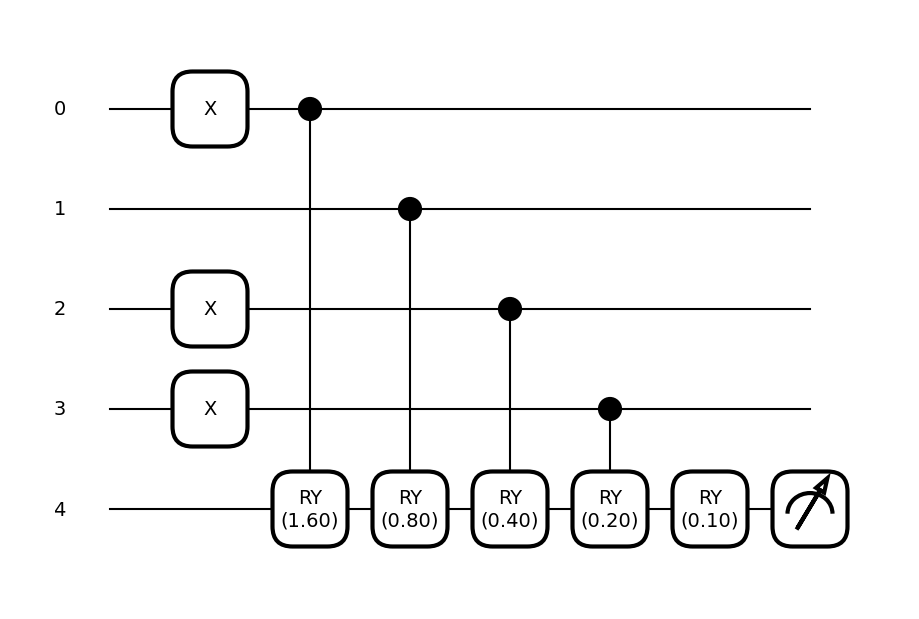

In [5]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(lc_circuit, decimals=2)(inputs, WEIGHTS, BIAS)
plt.show()

# print(qml.draw(lc_circuit)(INPUTS, WEIGHTS, BIAS))

## Build Activation Function Circuit

The other part of Quantum Neuron is activation function. Activation function part has linear combination part as subset.

<div align="center"><img src="activation_function_circuit.png"/></div>

\begin{align}
    &\left| x \right> \otimes \left| 0 \right> \otimes \left| \psi \right> \\
    &\xrightarrow{1} \left| x \right> \otimes Ry(2\theta) \left| 0 \right> \otimes \left| \psi \right> \\
    &\xrightarrow{2} \left| x \right> \otimes \left( \cos \theta \left| 0 \right> \otimes \left| \psi \right> + \sin \theta \left| 1 \right> \otimes Y\left| \psi \right> \right) \\
    &\xrightarrow{3} \left| x \right> \otimes \left( \cos \theta \cdot e^{\frac{\pi}{4} i} \left| 0 \right> \otimes \left| \psi \right> + \sin \theta \cdot e^{-\frac{\pi}{4} i} \left| 1 \right> \otimes Y\left| \psi \right> \right)\\
    &\xrightarrow{4} \cos \theta \cdot e^{\frac{\pi}{4} i} \left| x \right> \otimes \left( \cos \theta \left| 0 \right> - \sin \theta \left| 1 \right> \right) \otimes \left| \psi \right> \\
    &+ \sin \theta \cdot e^{-\frac{\pi}{4} i} \left| x \right> \otimes \left( \cos \theta \left| 1 \right> + \sin \theta \left| 0 \right>) \right) \otimes Y\left| \psi \right> \\
    &= \cos^2 \theta \cdot e^{\frac{\pi}{4} i} \left| x \right> \otimes \left| 0 \right> \otimes \left| \psi \right> -\cos \theta \sin \theta \cdot e^{\frac{\pi}{4} i} \left| x \right> \otimes \left| 1 \right> \otimes \left| \psi \right> \\
    &+ \cos \theta \sin \theta \cdot e^{-\frac{\pi}{4} i} \left| x \right> \otimes \left| 1 \right> \otimes Y \left| \psi \right> + \sin^2 \theta \cdot e^{-\frac{\pi}{4} i} \left| x \right> \otimes \left| 0 \right> \otimes Y \left| \psi \right> \\
    &\stackrel{\mathrm{def}}{=} \left| \Phi \right>
\end{align}
where the three terms separated by tensor product represent, from left to right, inputs, ancilla, and output qubit(s), respectively.

Next, in $\left| \Phi \right>$, we measure only ancilla qubit. Let $p_0$ be the probability of getting 0 of ancilla qubit, and $P_0$ be projection operator of that measuring,

\begin{align}
    P_0 &= I \otimes \left| 0 \right> \left< 0 \right| \otimes I \\
    p_0 &= \left< \Phi \right| P_0 \left| \Phi \right> \\
    &= \cos^4 \theta + \sin^4 \theta.
\end{align}

Therefore, let $\left| \Phi \right>_0$ be the $\left| \Phi \right>$ state after ancilla measured as 0,

\begin{align}
    \left| \Phi \right>_0 &= \frac{1}{\sqrt{p_0}} \left( \cos^2 \theta\cdot e^{\frac{\pi}{4} i} \left| x \right> \otimes \left| \psi \right> + \sin^2 \theta \cdot e^{-\frac{\pi}{4} i} \left| x \right> \otimes Y \left| \psi \right> \right) \\
    &= \frac{e^{\frac{\pi}{4} i}}{\sqrt{p_0}} \left| x \right> \otimes \left( I \cos^2 \theta - iY \sin^2 \theta \right) \left| \psi \right> \\
    &= e^{\frac{\pi}{4} i} \left| x \right> \otimes Ry \left( 2q(\theta) \right) \left| \psi \right>.
\end{align}

Similarly, let $p_1$ be the probability of getting 1 of ancilla qubit, and $\left| \Phi \right>_1$ be the $\left| \Phi \right>$ state after ancilla measured as 1,

\begin{align}
    p_1 &= 1-p_0 \\
    \left| \Phi \right>_1 &= \frac{1}{\sqrt{p_0}} \left( -\cos \theta \sin \theta \cdot e^{\frac{\pi}{4} i} \left| x \right> \otimes \left| \psi \right> + \cos \theta \sin \theta \cdot e^{-\frac{\pi}{4} i} \left| x \right> \otimes Y \left| \psi \right> \right) \\
    &= \frac{\cos \theta \sin \theta}{\sqrt{p_1}} \cdot \left( -e^{\frac{\pi}{4} i} \right) \left| x \right> \otimes \left( I + iY \right) \left| \psi \right> \\
    &= -e^{\frac{\pi}{4} i} \left| x \right> \otimes Ry \left( -\frac{\pi}{2} \right) \left| \psi \right>.
\end{align}

Consequently, we can get $Ry \left( 2q(\theta) \right) \left| \psi \right>$ when ancilla is measured as 0. If ancilla is measured as 1, we can correct the output qubit to $\left| 0 \right>$ by applying $Ry \left( \frac{\pi}{2} \right)$.

(In this work, we don't correct the output qubit in such "1" cases, and only adopt the "0" cases.)

In [6]:
N_QUBITS = len(WEIGHTS)+2  # +2: ancilla and output
OUTPUT = len(WEIGHTS) + 1  # ID of an output qubit

DEVICE = qml.device(
    "braket.aws.qubit", 
    device_arn="arn:aws:braket:::device/quantum-simulator/amazon/sv1", 
    s3_destination_folder=S3, 
    wires=N_QUBITS, 
    shots=1000)

In [7]:
@qml.qnode(DEVICE)
def af_circuit(inputs:str, weights:List[float], bias:float):  # af: activation function
    for qubit in range(len(inputs)):
        if(inputs[qubit]=='1'):
            qml.PauliX(qubit)
    
    for qubit in range(len(inputs)):
        qml.CRY(phi=2*weights[qubit], wires=[qubit, ANCILLA])
        
    qml.RY(2*bias, wires=ANCILLA)
    
    qml.CY(wires=[ANCILLA, OUTPUT])
    qml.RZ(phi=-np.pi/2, wires=ANCILLA)
    
    for qubit in range(len(inputs)):
        qml.CRY(phi=-2*weights[qubit], wires=[qubit, ANCILLA])  # note '-'
        
    qml.RY(-2*bias, wires=ANCILLA)  # note '-'
    
    return [qml.sample(qml.PauliZ(i)) for i in range(N_QUBITS)]

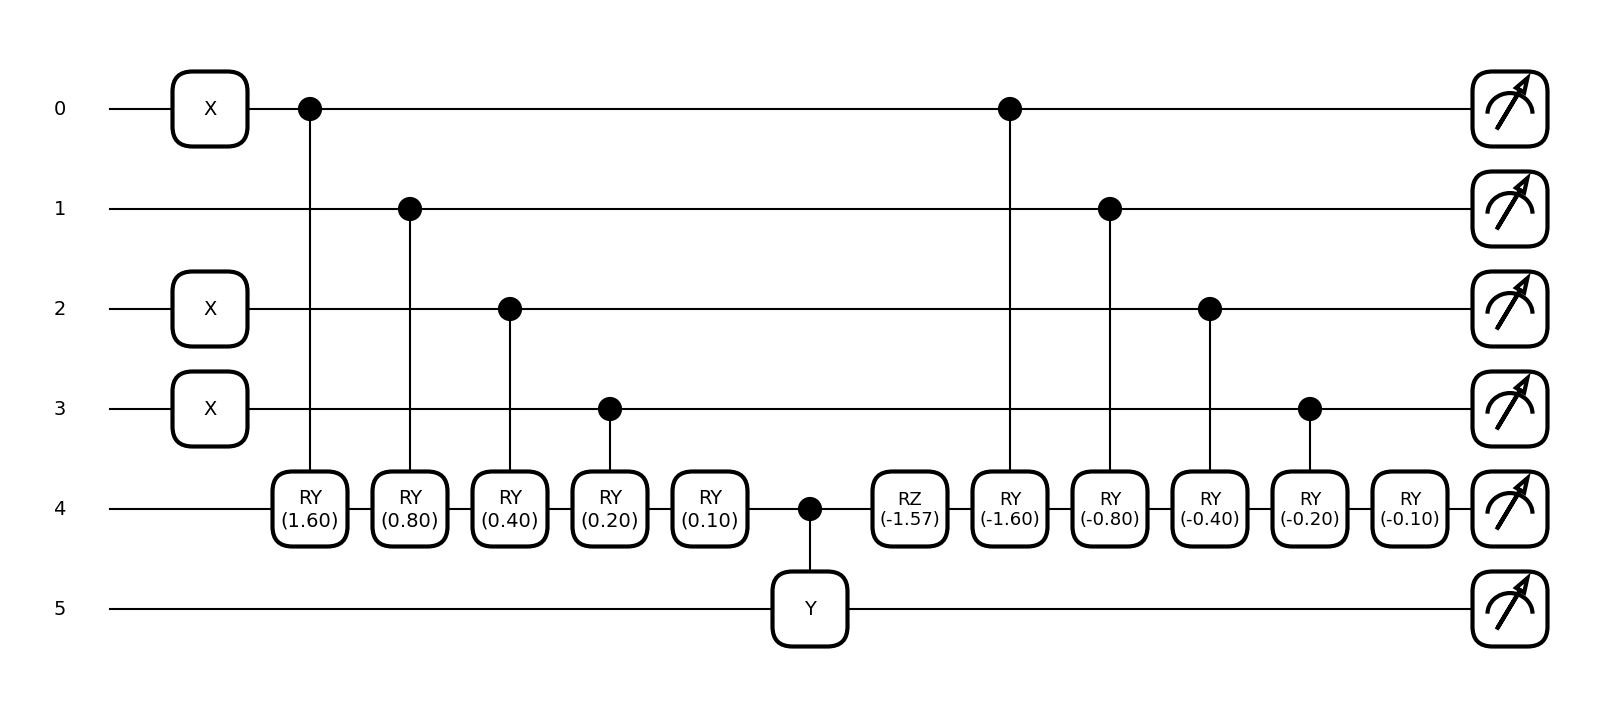

In [8]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(af_circuit, decimals=2)(inputs, WEIGHTS, BIAS)
plt.show()

In [9]:
sample = af_circuit(inputs, WEIGHTS, BIAS)
sample = sample.T
sample = (1 - sample.numpy()) / 2

In [10]:
print("First len(INPUTS) qubits should be correspond to INPUTS(=\"1011\"):")
print(sample)

First len(INPUTS) qubits should be correspond to INPUTS(="1011"):
[[1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1.]
 ...
 [1. 0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]]


In the sample obtained, we adopt the cases where its ancilla qubit is 0.

In [11]:
adopted_sample = sample[sample[:,ANCILLA] == 0]
adopted_sample

array([[1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0., 1.],
       ...,
       [1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0., 1.]])

The last qubit of `adopted_sample` represents a measurement result of $Ry(2q(\theta)) \left|0\right>$.

Let $p_0$ be the probability of 0 when measuring output qubit.
Using $ Ry(2q(\theta)) \left|0\right> = \cos q(\theta) \left|0\right> + \sin q(\theta) \left|1\right>$,
$$ p_0 = \cos^2 q(\theta) \\
\therefore q(\theta) = \cos^{-1}\sqrt{p_0}$$

In [12]:
count_0 = len(adopted_sample[adopted_sample[:,OUTPUT] == 0])
count_1 = len(adopted_sample[adopted_sample[:,OUTPUT] == 1])

p_0 = count_0 / (count_0 + count_1)
q_theta = np.arccos(np.sqrt(p_0))
print(q_theta)
print(theta)

1.3755034342395367
1.1500000000000001


## Run Quantum Neuron Circuit on AWS Simulator (SV1)

In [13]:
DEVICE = qml.device(
    "braket.aws.qubit", 
    device_arn="arn:aws:braket:::device/quantum-simulator/amazon/sv1", 
    s3_destination_folder=S3, 
    wires=N_QUBITS, 
    shots=1000)

In [17]:
def quantum_neuron(inputs:int):
    inputs = format(inputs, '04b')
    print(inputs)
    
    theta = np.inner(np.array(list(inputs), dtype=int), np.array(WEIGHTS)) + BIAS   # linear comination with numpy
    theta = theta.item()   # Convert numpy array to native python float-type
    theta_list.append(theta)

    sample = af_circuit(inputs, WEIGHTS, BIAS)
    sample = sample.T
    sample = (1 - sample.numpy()) / 2

    adopted_sample = sample[sample[:,ANCILLA] == 0]

    count_0 = len(adopted_sample[adopted_sample[:,OUTPUT] == 0])
    print(f'count_0: {count_0}')
    count_1 = len(adopted_sample[adopted_sample[:,OUTPUT] == 1])
    print(f'count_1: {count_1}')

    p_0 = count_0 / (count_0 + count_1)

    print(f'p_0: {p_0}')
    print()
    q_theta = np.arccos(np.sqrt(p_0))
    
    return q_theta

In [18]:
theta_list = []
sv1_q_theta_list = []

for inputs in range(2**len(WEIGHTS)):
    q_theta = quantum_neuron(inputs)
    
    sv1_q_theta_list.append(q_theta)

np.save('./theta_list.npy', theta_list)    
np.save('./sv1_q_theta_list.npy', sv1_q_theta_list)

0000
count_0: 999
count_1: 0
p_0: 1.0

0001
count_0: 962
count_1: 0
p_0: 1.0

0010
count_0: 888
count_1: 5
p_0: 0.9944008958566629

0011
count_0: 773
count_1: 12
p_0: 0.9847133757961783

0100
count_0: 629
count_1: 32
p_0: 0.9515885022692889

0101
count_0: 546
count_1: 86
p_0: 0.8639240506329114

0110
count_0: 411
count_1: 138
p_0: 0.7486338797814208

0111
count_0: 294
count_1: 229
p_0: 0.5621414913957935

1000
count_0: 189
count_1: 342
p_0: 0.3559322033898305

1001
count_0: 136
count_1: 444
p_0: 0.23448275862068965

1010
count_0: 69
count_1: 542
p_0: 0.11292962356792144

1011
count_0: 20
count_1: 706
p_0: 0.027548209366391185

1100
count_0: 11
count_1: 798
p_0: 0.013597033374536464

1101
count_0: 1
count_1: 896
p_0: 0.0011148272017837235

1110
count_0: 0
count_1: 973
p_0: 0.0

1111
count_0: 0
count_1: 999
p_0: 0.0



## Run Quantum Neuron Circuit on Real Quantum Device (IonQ)

In [4]:
DEVICE = qml.device(
    "braket.aws.qubit", 
    device_arn="arn:aws:braket:::device/qpu/ionq/ionQdevice", 
    s3_destination_folder=S3, 
    wires=N_QUBITS, 
    shots=1000)

In [6]:
theta_list = []
ionq_q_theta_list = []

for inputs in range(2**len(WEIGHTS)):
    q_theta = quantum_neuron(inputs)
    
    ionq_q_theta_list.append(q_theta)

np.save('./theta_list.npy', theta_list)    
np.save('./ionq_q_theta_list.npy', ionq_q_theta_list)

0000
count_0: 669
count_1: 61
p_0: 0.9164383561643835

0001
count_0: 673
count_1: 53
p_0: 0.9269972451790633

0010
count_0: 642
count_1: 71
p_0: 0.9004207573632539

0011
count_0: 543
count_1: 87
p_0: 0.861904761904762

0100
count_0: 516
count_1: 65
p_0: 0.8881239242685026

0101
count_0: 400
count_1: 155
p_0: 0.7207207207207207

0110
count_0: 261
count_1: 173
p_0: 0.6013824884792627

0111
count_0: 312
count_1: 199
p_0: 0.6105675146771037

1000
count_0: 260
count_1: 260
p_0: 0.5

1001
count_0: 199
count_1: 348
p_0: 0.36380255941499084

1010
count_0: 189
count_1: 452
p_0: 0.2948517940717629

1011
count_0: 117
count_1: 569
p_0: 0.17055393586005832

1100
count_0: 119
count_1: 609
p_0: 0.16346153846153846

1101
count_0: 87
count_1: 720
p_0: 0.10780669144981413

1110
count_0: 62
count_1: 739
p_0: 0.07740324594257178

1111
count_0: 76
count_1: 730
p_0: 0.09429280397022333



## Run Quantum Neuron Circuit on Real Quantum Device (Aspen-M-2)

In [4]:
DEVICE = qml.device("braket.aws.qubit", 
                    device_arn="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2", 
                    s3_destination_folder=S3, 
                    wires=N_QUBITS, 
                    shots=1000)

In [6]:
theta_list = []
aspen_q_theta_list = []

for inputs in range(2**len(WEIGHTS)):
    q_theta = quantum_neuron(inputs)
    
    aspen_q_theta_list.append(q_theta)

np.save('./theta_list.npy', theta_list)    
np.save('./sv1_q_theta_list.npy', aspen_q_theta_list)

0000
count_0: 138
count_1: 146
p_0: 0.4859154929577465

0001
count_0: 165
count_1: 173
p_0: 0.4881656804733728

0010
count_0: 119
count_1: 118
p_0: 0.5021097046413502

0011
count_0: 205
count_1: 111
p_0: 0.6487341772151899

0100
count_0: 116
count_1: 159
p_0: 0.4218181818181818

0101
count_0: 138
count_1: 173
p_0: 0.4437299035369775

0110
count_0: 150
count_1: 111
p_0: 0.5747126436781609

0111
count_0: 146
count_1: 125
p_0: 0.5387453874538746

1000
count_0: 137
count_1: 121
p_0: 0.5310077519379846

1001
count_0: 108
count_1: 183
p_0: 0.3711340206185567

1010
count_0: 214
count_1: 126
p_0: 0.6294117647058823

1011
count_0: 175
count_1: 111
p_0: 0.6118881118881119

1100
count_0: 124
count_1: 157
p_0: 0.4412811387900356

1101
count_0: 143
count_1: 164
p_0: 0.46579804560260585

1110
count_0: 143
count_1: 128
p_0: 0.5276752767527675

1111
count_0: 150
count_1: 153
p_0: 0.49504950495049505



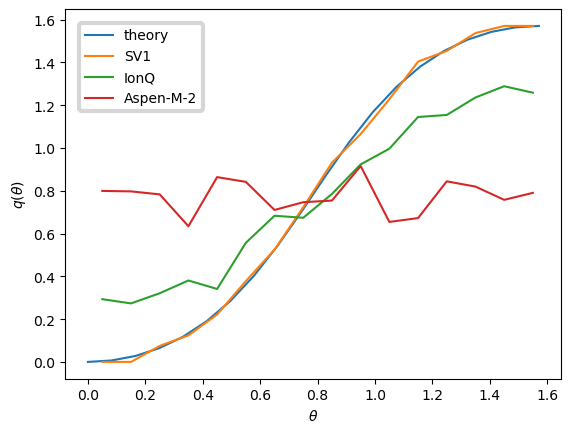

In [19]:
x_array = np.linspace(0, np.pi/2, 20)
nl_function = np.arctan(np.tan(x_array)**2)
theta_list = np.load('./theta_list.npy')
sv1_q_theta_list = np.load('./sv1_q_theta_list.npy')
ionq_q_theta_list = np.load('./ionq_q_theta_list.npy')
aspen_q_theta_list = np.load('./aspen_q_theta_list.npy')

plt.plot(x_array, nl_function, label=r"theory")
plt.plot(theta_list, sv1_q_theta_list, label=r"SV1")
plt.plot(theta_list, ionq_q_theta_list, label=r"IonQ")
plt.plot(theta_list, aspen_q_theta_list, label=r"Aspen-M-2")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$q(\theta)$")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1)
plt.show()

## Summary

We can run Quantum Neuron circuit on different quantum devices through pennylane.